<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 DLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[Reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/DLinear.py <br>
https://anweh.tistory.com/21

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [52]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [53]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/5.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.739264
1,0.737200
2,0.759168
3,0.741552
4,0.749392
...,...
38875,0.652168
38876,0.664736
38877,0.678984
38878,0.653888


In [54]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-DLinear']

In [55]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [56]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [57]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
#         seasonal_init,trend_init = seasonal_init.cpu(), trend_init.cpu() 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
        
        x = seasonal_output + trend_output
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [58]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [59]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [60]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-05.


<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [61]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.5000e-06.
smape 30.9460617534337 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 20.814913450386268 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 19.908078969592413 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 19.08749872796804 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 19.282863118865514 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 19.013763580373244 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 16.270367275073863 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 17.66731635133643 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 15.437765996140696 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 16.503173615020966 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 15.897989348829752 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 15.196611137559627 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 14.621745436043854 %
Adj

In [62]:
torch.manual_seed(42)

In [63]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [64]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model2.pt') 
# 모델의 갱신의 loss가 현재 알고있는 값과 그 이전의 값으로 갱신이 되는데 이게 새로운 모델의 예측에선 안맞을 수 있다
# 기존 2%대 성능에서 0.3% 로 성능 개선 
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
    #model = torch.load(PATH+'/best_model2.pt') 
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 3.2012927960604425 %
SMAPE 5.030152607709169 %
SMAPE 0.22450828705950698 %
SMAPE 0.24206671054162143 %
SMAPE 0.20357492679158895 %
SMAPE 0.2436242498915817 %
SMAPE 1.9398523503914478 %
SMAPE 0.4436177914087693 %
SMAPE 5.258393503725529 %
SMAPE 10.568166814744473 %
SMAPE 8.326236434280872 %
SMAPE 11.988862663507462 %
SMAPE 5.333448715507984 %
SMAPE 0.6406274436794774 %
SMAPE 0.26075415764989884 %
SMAPE 0.9690303721738474 %
SMAPE 0.37337757332295496 %
SMAPE 0.5953236627083243 %
SMAPE 0.5917091138626347 %
SMAPE 0.5942396943278254 %
SMAPE 3.8039557468146086 %
SMAPE 0.5157928109238128 %
SMAPE 1.205907251634926 %
SMAPE 0.0324589251137013 %
SMAPE 0.7607604604809239 %
SMAPE 1.6682758464012297 %
SMAPE 1.490539437159896 %
SMAPE 3.3779109362512827 %
SMAPE 2.7518591713160276 %
SMAPE 3.720080090686679 %
SMAPE 3.2768626008182764 %
SMAPE 2.1519686533138156 %
SMAPE 0.3223594230234994 %
SMAPE 1.3271332604817871 %
SMAPE 0.14730859564684806 %
SMAPE 1.0770636088127503 %
SMAPE 2.602351885288954 %
SMA

SMAPE 12.801398225128652 %
SMAPE 10.811377950012684 %
SMAPE 1.076592062259806 %
SMAPE 0.11928269331269803 %
SMAPE 0.2729485762297372 %
SMAPE 2.7727479487657547 %
SMAPE 0.6556942809202155 %
SMAPE 5.490095775574446 %
SMAPE 2.4051782079041004 %
SMAPE 1.6632762260196614 %
SMAPE 0.17386308712070786 %
SMAPE 1.655237639322877 %
SMAPE 2.0306717826315435 %
SMAPE 1.6018645015574293 %
SMAPE 3.6934286206960683 %
SMAPE 0.06703656944387149 %
SMAPE 0.15952960668187188 %
SMAPE 3.5289558805525303 %
SMAPE 7.199340425431728 %
SMAPE 2.5701230065897107 %
SMAPE 4.2817822732031345 %
SMAPE 0.22782478375034998 %
SMAPE 1.8220568941906095 %
SMAPE 1.2162851992407013 %
SMAPE 4.347551358863711 %
SMAPE 0.5633134817780956 %
SMAPE 2.9910355852916837 %
SMAPE 5.609672103077173 %
SMAPE 0.6642715276057061 %
SMAPE 3.960620867088437 %
SMAPE 7.4613609723746785 %
SMAPE 3.374726360663772 %
SMAPE 0.20267439690087483 %
SMAPE 3.3001315221190453 %
SMAPE 5.500441059470177 %
SMAPE 3.5488536600023513 %
SMAPE 0.5984510129342198 %
SMAP

SMAPE 1.1275382991880178 %
SMAPE 1.387014209292829 %
SMAPE 1.9823319297283888 %
SMAPE 0.1206307276237908 %
SMAPE 0.6417487752623856 %
SMAPE 0.39399812719784677 %
SMAPE 0.028592647849137624 %
SMAPE 0.7591129904612899 %
SMAPE 0.1892611474104342 %
SMAPE 0.182670101820122 %
SMAPE 1.2401060005649924 %
SMAPE 0.003276410742756753 %
SMAPE 0.20500587663082112 %
SMAPE 0.6668716170825064 %
SMAPE 0.47645626822486514 %
SMAPE 0.16949497852147033 %
SMAPE 1.4676757184788585 %
SMAPE 0.5961375182960182 %
SMAPE 0.9400314232334496 %
SMAPE 0.003977307035917477 %
SMAPE 0.09298822848114696 %
SMAPE 0.40190785157028586 %
SMAPE 1.369544985704124 %
SMAPE 1.7964937435463073 %
SMAPE 1.538784520700574 %
SMAPE 1.1916985418647528 %
SMAPE 0.5736931047867984 %
SMAPE 0.12168803284441765 %
SMAPE 1.256700238212943 %
SMAPE 3.155901050195098 %
SMAPE 1.5637158518657088 %
SMAPE 1.3771842140704393 %
SMAPE 0.11530090392534474 %
SMAPE 1.041322791017592 %
SMAPE 0.8291549873538315 %
SMAPE 0.37039916939102113 %
SMAPE 0.180813725455

SMAPE 0.4395557183306665 %
SMAPE 1.1148174041882157 %
SMAPE 0.30008913468918763 %
SMAPE 0.30371081409975886 %
SMAPE 0.013145416800540486 %
SMAPE 1.7284843102097511 %
SMAPE 0.5744132183026522 %
SMAPE 2.1163844764232635 %
SMAPE 0.5112647651694715 %
SMAPE 0.43237253930419683 %
SMAPE 0.00760979426596009 %
SMAPE 1.63502390217036 %
SMAPE 0.7195233325473964 %
SMAPE 0.696735090110451 %
SMAPE 0.8376787113957108 %
SMAPE 1.099448312073946 %
SMAPE 0.3765120893949643 %
SMAPE 0.8548217373900115 %
SMAPE 0.06375557462536108 %
SMAPE 0.0028357582142746196 %
SMAPE 0.0009687474614565872 %
SMAPE 0.7141544856131077 %
SMAPE 1.3075689226388931 %
SMAPE 1.927896386012435 %
SMAPE 2.1221386212855577 %
SMAPE 0.768980445805937 %
SMAPE 0.18402751288704167 %
SMAPE 1.1155171794816852 %
SMAPE 1.0776819232851267 %
SMAPE 0.05423527303156561 %
SMAPE 0.15602729804504634 %
SMAPE 0.2264008083693625 %
SMAPE 2.391581689938903 %
SMAPE 1.450620918534696 %
SMAPE 0.059616248756555024 %
SMAPE 0.1823564157293731 %
SMAPE 0.8921356992

SMAPE 0.13559526007520617 %
SMAPE 1.9707566406577826 %
SMAPE 0.008827707038278731 %
SMAPE 0.013141549443730584 %
SMAPE 0.020478523273993687 %
SMAPE 0.13390422447196215 %
SMAPE 0.8436049502342939 %
SMAPE 0.9813232966698705 %
SMAPE 0.28071810882829595 %
SMAPE 0.08794228610781829 %
SMAPE 0.2184843202303455 %
SMAPE 1.737759042531252 %
SMAPE 0.24126611127667275 %
SMAPE 0.02114186313747979 %
SMAPE 0.7587209707126021 %
SMAPE 0.5068504883674905 %
SMAPE 2.120846673846245 %
SMAPE 0.7942223735153676 %
SMAPE 0.06029464853736499 %
SMAPE 0.19309196955691732 %
SMAPE 0.3872511858062353 %
SMAPE 1.6206729402765634 %
SMAPE 0.017896183610261573 %
SMAPE 1.1632536887191236 %
SMAPE 0.14091732002543722 %
SMAPE 1.1027047443203628 %
SMAPE 0.39674945806473266 %
SMAPE 0.4167880692548352 %
SMAPE 0.47944370750337845 %
SMAPE 0.724739967379719 %
SMAPE 0.09088820426126176 %
SMAPE 0.2877519221910916 %
SMAPE 0.5081181926652789 %
SMAPE 0.5535164774628356 %
SMAPE 1.8495722692459822 %
SMAPE 0.09029424593154545 %
SMAPE 0.68

SMAPE 4.926781449466944 %
SMAPE 2.3505644192919135 %
SMAPE 0.21734277562052284 %
SMAPE 0.24667640741925823 %
SMAPE 3.406661242246628 %
SMAPE 1.7517199702560902 %
SMAPE 0.5241383057688154 %
SMAPE 0.6076478615632368 %
SMAPE 1.755066426238045 %
SMAPE 0.11838144392225304 %
SMAPE 1.2551330986207176 %
SMAPE 5.74310053512454 %
SMAPE 0.37933289683610383 %
SMAPE 1.8802690904121848 %
SMAPE 0.5318754858330976 %
SMAPE 1.6947435182519257 %
SMAPE 0.594674485084397 %
SMAPE 1.6959144768770786 %
SMAPE 2.0762761482037604 %
SMAPE 0.020403560210837668 %
SMAPE 6.649288114160299 %
SMAPE 0.37803580289619276 %
SMAPE 2.779272358864546 %
SMAPE 3.878859288990497 %
SMAPE 8.499514371156693 %
SMAPE 0.36559188004230236 %
SMAPE 4.135306760668755 %
SMAPE 0.4842938347969721 %
SMAPE 3.384541120380163 %
SMAPE 0.22321327942665903 %
SMAPE 1.9606469798600301 %
SMAPE 2.385314636398107 %
SMAPE 7.352926149964333 %
SMAPE 2.612058670260012 %
SMAPE 1.309671502749552 %
SMAPE 0.9483404051625257 %
SMAPE 0.2683542916234387 %
SMAPE 2.

SMAPE 1.840487226843834 %
SMAPE 4.457949589937925 %
SMAPE 1.1303784053307027 %
SMAPE 0.6237968081622967 %
SMAPE 0.3125216658295358 %
SMAPE 0.11488106785793661 %
SMAPE 1.82342738751322 %
SMAPE 2.093292085453868 %
SMAPE 1.478843869175762 %
SMAPE 0.12399919634481195 %
SMAPE 0.1663584820844335 %
SMAPE 2.7540913093835115 %
SMAPE 0.06841954749752688 %
SMAPE 6.457509644329548 %
SMAPE 9.968293659389019 %
SMAPE 6.207692079246044 %
SMAPE 5.645783070474863 %
SMAPE 1.8300534570589662 %
SMAPE 2.8116087466478348 %
SMAPE 0.6155673697903694 %
SMAPE 1.5990232550539076 %
SMAPE 0.9689175540916038 %
SMAPE 1.34837667318061 %
SMAPE 0.5585263605935324 %
SMAPE 1.078519719070755 %
SMAPE 0.0801947849189446 %
SMAPE 1.7601035917177796 %
SMAPE 2.010922289453447 %
SMAPE 0.09244436154556013 %
SMAPE 0.3020067775236157 %
SMAPE 3.039264900609851 %
SMAPE 0.23176802702391794 %
SMAPE 0.1943482103284282 %
SMAPE 1.9926706375554204 %
SMAPE 0.1616539710703364 %
SMAPE 0.42374759718495625 %
SMAPE 0.008852689777654632 %
SMAPE 0.

SMAPE 0.049659770581001794 %
SMAPE 2.074102582409978 %
SMAPE 1.3909607203677297 %
SMAPE 0.005174867236718228 %
SMAPE 0.05336457845368159 %
SMAPE 0.33345053170342 %
SMAPE 0.24750576540282054 %
SMAPE 0.33574446610873565 %
SMAPE 0.31626359309302643 %
SMAPE 0.020777448627796957 %
SMAPE 0.16484702883326463 %
SMAPE 0.39348275901284074 %
SMAPE 1.9101068116724491 %
SMAPE 0.2483041476825747 %
SMAPE 0.5355012754444033 %
SMAPE 0.7315930696204305 %
SMAPE 0.1758305759186669 %
SMAPE 0.71513447817415 %
SMAPE 0.06668063373979294 %
SMAPE 0.7778660198673606 %
SMAPE 1.6676045656204224 %
SMAPE 0.8050542743876575 %
SMAPE 0.14051533467494437 %
SMAPE 0.03930539983457493 %
SMAPE 0.055104635266843616 %
SMAPE 0.6151523450389504 %
SMAPE 0.025515927904848464 %
SMAPE 1.3759617768228054 %
SMAPE 0.8171152789145708 %
SMAPE 0.00994262691553871 %
SMAPE 0.12505181299911783 %
SMAPE 0.19741046813942376 %
SMAPE 0.03724319500459217 %
SMAPE 0.761869989335537 %
SMAPE 1.1263234354555607 %
SMAPE 0.47215323173440993 %
SMAPE 0.09

SMAPE 0.049893134689973806 %
SMAPE 0.46099031611811375 %
SMAPE 0.006884285889100283 %
SMAPE 0.7491788016632199 %
SMAPE 0.28439822224072486 %
SMAPE 0.14612225999609052 %
SMAPE 1.4414565777406096 %
SMAPE 0.49615763779729605 %
SMAPE 1.0642023859545588 %
SMAPE 0.14419173394981044 %
SMAPE 0.004645918153826756 %
SMAPE 0.03780355979958472 %
SMAPE 0.9132339316420258 %
SMAPE 0.18134524086669046 %
SMAPE 0.0593720791619603 %
SMAPE 0.592498890357092 %
SMAPE 0.015412025608043221 %
SMAPE 0.09425765060939284 %
SMAPE 2.1118037570267916 %
SMAPE 0.44374031806364655 %
SMAPE 1.1538105374202132 %
SMAPE 1.0130581315606833 %
SMAPE 1.088058996014297 %
SMAPE 0.35977923328755423 %
SMAPE 0.07701207579071934 %
SMAPE 0.24220643811167977 %
SMAPE 1.8963692877441645 %
SMAPE 0.7739471467211843 %
SMAPE 0.008998665157633923 %
SMAPE 0.12222002426051402 %
SMAPE 0.9896600442007184 %
SMAPE 0.8892270838841796 %
SMAPE 0.1600731393064052 %
SMAPE 0.8775180103257298 %
SMAPE 0.5833992178086191 %
SMAPE 0.7497533289715648 %
SMAPE 0

SMAPE 1.5765996761620045 %
SMAPE 0.16134230675129402 %
SMAPE 1.6774033140391114 %
SMAPE 0.4377459258357703 %
SMAPE 0.8196879024617375 %
SMAPE 1.3079009503126144 %
SMAPE 1.6097882557660341 %
SMAPE 0.00977957723952727 %
SMAPE 0.9832728519104421 %
SMAPE 0.13085514394865072 %
SMAPE 2.0155006973072886 %
SMAPE 0.13442055943141895 %
SMAPE 0.11613964802745613 %
SMAPE 0.628919908660464 %
SMAPE 0.04958702650168334 %
SMAPE 1.2245516534894705 %
SMAPE 1.1708103632554412 %
SMAPE 0.6097586069372483 %
SMAPE 0.007226383387887837 %
SMAPE 0.9263662283774464 %
SMAPE 2.0035619884729385 %
SMAPE 2.863966967910528 %
SMAPE 1.9560297690331936 %
SMAPE 0.7176915083546191 %
SMAPE 1.194685849826783 %
SMAPE 0.45371361623983825 %
SMAPE 1.313392473384738 %
SMAPE 1.0812234724871814 %
SMAPE 1.4150171149522066 %
SMAPE 0.0531613389906056 %
SMAPE 0.0039164592790967845 %
SMAPE 0.5685513592816278 %
SMAPE 0.2242953995745083 %
SMAPE 0.11014824966673586 %
SMAPE 0.01857797267530259 %
SMAPE 0.14595210716481688 %
SMAPE 2.788190582

SMAPE 1.9496937355227146 %
SMAPE 2.2972782253855257 %
SMAPE 3.0153439990535844 %
SMAPE 9.878447644412518 %
SMAPE 5.171214673668146 %
SMAPE 5.130417095497251 %
SMAPE 0.06602623945536834 %
SMAPE 4.5923860957846045 %
SMAPE 0.2665867933709336 %
SMAPE 1.2634428086275875 %
SMAPE 2.2434478719515027 %
SMAPE 0.5793106546243507 %
SMAPE 0.3379445274817954 %
SMAPE 7.7624229490757 %
SMAPE 0.7125724094505586 %
SMAPE 4.6551955826580524 %
SMAPE 0.9106569006216887 %
SMAPE 0.22580650544796302 %
SMAPE 3.308064279292012 %
SMAPE 9.255697309970856 %
SMAPE 1.0257999646455573 %
SMAPE 0.1622816915914882 %
SMAPE 0.7010796682843647 %
SMAPE 0.23447511531730927 %
SMAPE 0.33260604708721075 %
SMAPE 0.10888082157896406 %
SMAPE 3.1946034327120287 %
SMAPE 0.15811430773192114 %
SMAPE 0.2222351754135161 %
SMAPE 10.63969012349844 %
SMAPE 0.5309536728536841 %
SMAPE 1.1696317960813758 %
SMAPE 14.344438850879671 %
SMAPE 4.357374714687467 %
SMAPE 1.2822860909500378 %
SMAPE 2.8253369135491084 %
SMAPE 12.246660247445107 %
SMAPE

SMAPE 0.6161811624187976 %
SMAPE 0.004792509250940213 %
SMAPE 1.0440010726451874 %
SMAPE 2.108493745326996 %
SMAPE 0.2639153214522594 %
SMAPE 0.005354633185689295 %
SMAPE 0.9777853935956956 %
SMAPE 2.561588115990162 %
SMAPE 1.0307287741452456 %
SMAPE 0.43663710051623633 %
SMAPE 2.657715156674385 %
SMAPE 0.24669214053778887 %
SMAPE 0.03655003584387373 %
SMAPE 0.8272765129804611 %
SMAPE 2.390237407758832 %
SMAPE 0.4224271841376321 %
SMAPE 0.07266552905090862 %
SMAPE 0.5743322017369792 %
SMAPE 1.5003616223111749 %
SMAPE 0.7520482356194407 %
SMAPE 1.1778677641414106 %
SMAPE 1.7045473279431462 %
SMAPE 2.0552203487604856 %
SMAPE 0.1524801082751992 %
SMAPE 3.010591506958008 %
SMAPE 2.740671757608652 %
SMAPE 0.029818027923028012 %
SMAPE 0.7616890678182244 %
SMAPE 2.1400579903274775 %
SMAPE 0.18834689062441612 %
SMAPE 0.9756367271766067 %
SMAPE 2.841411989182234 %
SMAPE 2.2801480889320374 %
SMAPE 1.8166156550869346 %
SMAPE 2.4811475165188313 %
SMAPE 0.9723427277058362 %
SMAPE 2.5775166414678097

SMAPE 1.9585832823067904 %
SMAPE 0.4527175893308595 %
SMAPE 1.179440469481051 %
SMAPE 1.2768106181174517 %
SMAPE 1.1821457529440522 %
SMAPE 0.5041431316640228 %
SMAPE 0.18165325616519112 %
SMAPE 0.12941299375597737 %
SMAPE 0.03883072361378481 %
SMAPE 0.02349951124503491 %
SMAPE 0.15839557114395575 %
SMAPE 0.8389044464565812 %
SMAPE 0.15683590104345058 %
SMAPE 0.6529845083132386 %
SMAPE 0.39205113146454096 %
SMAPE 0.014371637687190741 %
SMAPE 0.6230048106517643 %
SMAPE 0.13213965537602235 %
SMAPE 0.11144508506458804 %
SMAPE 0.4019328833092004 %
SMAPE 1.08984140958637 %
SMAPE 0.19041828473336864 %
SMAPE 1.179120833054185 %
SMAPE 0.005003847431510167 %
SMAPE 1.5520623251795769 %
SMAPE 2.036128766834736 %
SMAPE 0.37106505944393575 %
SMAPE 0.008255910127445532 %
SMAPE 0.0491283055812346 %
SMAPE 2.1223013550043106 %
SMAPE 2.411409681662917 %
SMAPE 3.1361935138702393 %
SMAPE 3.137453205883503 %
SMAPE 1.4464513966813684 %
SMAPE 1.4888036968186498 %
SMAPE 0.49180167564190924 %
SMAPE 0.888543896

SMAPE 0.858521589078009 %
SMAPE 0.016808411798095335 %
SMAPE 2.0966882538050413 %
SMAPE 0.5218262353446335 %
SMAPE 0.47295644623227423 %
SMAPE 0.4599148049019277 %
SMAPE 0.9536382053047419 %
SMAPE 0.6775102121755481 %
SMAPE 0.5839987315703183 %
SMAPE 0.34584989165887237 %
SMAPE 0.08946962554074389 %
SMAPE 0.771907901391387 %
SMAPE 0.5605586785823107 %
SMAPE 0.0481337731334861 %
SMAPE 1.8903119806200266 %
SMAPE 0.0646857915697936 %
SMAPE 0.39502273814287037 %
SMAPE 0.5770198805257678 %
SMAPE 1.9605178944766524 %
SMAPE 0.39979556505568326 %
SMAPE 0.7945045623928307 %
SMAPE 1.3709941813722253 %
SMAPE 0.6245747483335435 %
SMAPE 0.43337246880400926 %
SMAPE 1.502218416891992 %
SMAPE 0.5678507559932768 %
SMAPE 0.8452177671715617 %
SMAPE 1.1132168406620622 %
SMAPE 0.1154737974550244 %
SMAPE 0.10457732953841514 %
SMAPE 0.6500501944683492 %
SMAPE 0.4792216420173645 %
SMAPE 2.582337375730276 %
SMAPE 3.498279564082622 %
SMAPE 1.954392671585083 %
SMAPE 0.16233288652119882 %
SMAPE 0.0359877217671282

SMAPE 0.02168233323482127 %
SMAPE 0.34532562131698796 %
SMAPE 1.1604868383146822 %
SMAPE 5.367266550660133 %
SMAPE 0.05777055953797117 %
SMAPE 3.421152040362358 %
SMAPE 3.4398240000009537 %
SMAPE 4.054128892719746 %
SMAPE 2.5093316938728094 %
SMAPE 0.7320370679954067 %
SMAPE 0.11170497728136297 %
SMAPE 0.4652321813375692 %
SMAPE 0.5649159506283468 %
SMAPE 4.313453916460276 %
SMAPE 2.7989169601351023 %
SMAPE 0.04186167282129816 %
SMAPE 1.9049233924597502 %
SMAPE 2.830947710201144 %
SMAPE 2.846394009888172 %
SMAPE 1.9021500954404473 %
SMAPE 0.5494160557650503 %
SMAPE 0.10156898287823424 %
SMAPE 0.1472559809950269 %
SMAPE 0.5913544754730538 %
SMAPE 0.28325774811264637 %
SMAPE 0.6865192484874569 %
SMAPE 1.0670268083922565 %
SMAPE 0.9516387630719692 %
SMAPE 0.8808155846782028 %
SMAPE 1.909571800380945 %
SMAPE 4.499138779938221 %
SMAPE 0.006532716068619493 %
SMAPE 1.2233104552142322 %
SMAPE 1.2633123728446662 %
SMAPE 0.1595653005618658 %
SMAPE 0.29838386486790114 %
SMAPE 0.12928702644092027 

SMAPE 1.49813972719312 %
SMAPE 5.118680076673627 %
SMAPE 3.2149268193170424 %
SMAPE 0.24621871166453957 %
SMAPE 6.220671620219946 %
SMAPE 1.2472027842777607 %
SMAPE 3.229641983227339 %
SMAPE 4.145790518261492 %
SMAPE 1.1418370025548938 %
SMAPE 2.9114771309687058 %
SMAPE 0.8477491007120079 %
SMAPE 4.508248538710177 %
SMAPE 0.9595936149264618 %
SMAPE 2.453182597339037 %
SMAPE 0.34291708450177794 %
SMAPE 11.555068746209145 %
SMAPE 16.71277405321598 %
SMAPE 12.364037826657295 %
SMAPE 6.052073350176215 %
SMAPE 0.07772246399440519 %
SMAPE 3.2856668716995046 %
SMAPE 0.5164534421110147 %
SMAPE 0.561204470071516 %
SMAPE 11.647364668548107 %
SMAPE 0.7053938646204188 %
SMAPE 5.5820318926125765 %
SMAPE 7.085690200328827 %
SMAPE 2.0265156614805164 %
SMAPE 7.619313720613718 %
SMAPE 6.268653184175492 %
SMAPE 0.3549383628509588 %
SMAPE 4.9365892093628645 %
SMAPE 0.3840818865696747 %
SMAPE 0.18652548881027542 %
SMAPE 1.6452638771024795 %
SMAPE 0.6894514014388733 %
SMAPE 6.823316868394613 %
SMAPE 2.8328

SMAPE 2.304474776610732 %
SMAPE 0.5792220924049616 %
SMAPE 0.049323655677369516 %
SMAPE 1.2860693391412497 %
SMAPE 0.8535950439982115 %
SMAPE 1.5518644219264388 %
SMAPE 0.013332172630356354 %
SMAPE 3.0501912403851748 %
SMAPE 1.2954581286758184 %
SMAPE 1.6078598164021969 %
SMAPE 0.06973284309560768 %
SMAPE 1.933903628960252 %
SMAPE 0.6249762342777103 %
SMAPE 0.13341935455480325 %
SMAPE 0.3281423760836333 %
SMAPE 1.297163126990199 %
SMAPE 1.2662869673222303 %
SMAPE 0.31448322499272763 %
SMAPE 0.19947725509587144 %
SMAPE 0.39534275486948894 %
SMAPE 0.8482929063029587 %
SMAPE 0.9872934333980083 %
SMAPE 0.1149918329913646 %
SMAPE 1.0195535412058234 %
SMAPE 0.231286055952296 %
SMAPE 1.3045504419133067 %
SMAPE 0.9912078096531332 %
SMAPE 0.023530105986822036 %
SMAPE 0.018680757383435775 %
SMAPE 0.7556956885382533 %
SMAPE 0.21870738004054147 %
SMAPE 0.7876435001380742 %
SMAPE 0.6881927442736924 %
SMAPE 1.283277990296483 %
SMAPE 0.0647006122349012 %
SMAPE 0.45839654991868883 %
SMAPE 2.0809788368

SMAPE 0.009134313911886238 %
SMAPE 0.8747892058454453 %
SMAPE 1.8711999878287315 %
SMAPE 1.058657488785684 %
SMAPE 0.17759372706996146 %
SMAPE 0.39410233008675283 %
SMAPE 0.009380298374821905 %
SMAPE 0.010546741847193175 %
SMAPE 0.32556396682048216 %
SMAPE 0.07378085990546879 %
SMAPE 0.8843974899500608 %
SMAPE 0.5235136824194342 %
SMAPE 0.1879596207263603 %
SMAPE 0.04490084761829394 %
SMAPE 0.22396275081473502 %
SMAPE 0.952239103615284 %
SMAPE 0.3793807675829157 %
SMAPE 0.059671829602109476 %
SMAPE 0.06217862233233973 %
SMAPE 0.03392511944166898 %
SMAPE 0.0630444477550327 %
SMAPE 0.7597382212989032 %
SMAPE 1.2453500889241695 %
SMAPE 1.1835570437833667 %
SMAPE 0.5465641154441983 %
SMAPE 0.16878098911456618 %
SMAPE 0.2765424059180077 %
SMAPE 0.15875088731309006 %
SMAPE 1.1072866739705205 %
SMAPE 0.4217942851828411 %
SMAPE 0.2342605765261396 %
SMAPE 0.43697819975204766 %
SMAPE 0.5038915954064578 %
SMAPE 0.13434164533583726 %
SMAPE 0.004716035789954276 %
SMAPE 0.0012882434803174192 %
SMAPE

SMAPE 0.21312108131132848 %
SMAPE 0.37684209761209786 %
SMAPE 0.2101398106378838 %
SMAPE 0.05685253926890255 %
SMAPE 0.05836330699958126 %
SMAPE 0.0521627409220855 %
SMAPE 0.19345585164683143 %
SMAPE 0.37886827311012894 %
SMAPE 0.06322707435799657 %
SMAPE 0.13072060621959736 %
SMAPE 0.07703847231340433 %
SMAPE 0.21792155826733506 %
SMAPE 0.0008469384776788048 %
SMAPE 0.48393660015426576 %
SMAPE 0.27198174511431716 %
SMAPE 0.006111869025858141 %
SMAPE 0.12957187463962327 %
SMAPE 0.007992444268978716 %
SMAPE 0.27189749604440294 %
SMAPE 0.040244923043815106 %
SMAPE 0.0043179243476529905 %
SMAPE 1.202141486108303 %
SMAPE 0.5796528323553503 %
SMAPE 0.14647455990598246 %
SMAPE 0.449338716454804 %
SMAPE 0.2456005380076931 %
SMAPE 1.011924953199923 %
SMAPE 0.7270938009023666 %
SMAPE 1.3882316648960114 %
SMAPE 0.8129244302399457 %
SMAPE 0.23969650641492993 %
SMAPE 0.008723815014597847 %
SMAPE 0.02465438137669196 %
SMAPE 1.4907912677153945 %
SMAPE 1.3693260150030255 %
SMAPE 0.3397133281105198 %


SMAPE 0.9380277600139381 %
SMAPE 2.6008370500057936 %
SMAPE 0.05903330840533272 %
SMAPE 2.329952150583267 %
SMAPE 5.423923276364803 %
SMAPE 0.04446437703475681 %
SMAPE 1.9482035599648955 %
SMAPE 3.3690214976668362 %
SMAPE 1.142146393074654 %
SMAPE 2.607449596747756 %
SMAPE 1.1937818571459502 %
SMAPE 1.4905610256828368 %
SMAPE 1.3686328758485615 %
SMAPE 0.45378734207497473 %
SMAPE 0.08215740177638509 %
SMAPE 2.45256522949785 %
SMAPE 4.1870564967393875 %
SMAPE 0.052063892980100945 %
SMAPE 2.4019769113510847 %
SMAPE 0.7469548905755801 %
SMAPE 1.349690353963524 %
SMAPE 1.0864305292489007 %
SMAPE 0.6171443239791188 %
SMAPE 1.4282607268542051 %
SMAPE 3.3820121586322784 %
SMAPE 0.5404679848188607 %
SMAPE 0.3493149342257311 %
SMAPE 0.5774604744360659 %
SMAPE 4.2891025729477406 %
SMAPE 0.8986492729454766 %
SMAPE 0.5110522956347268 %
SMAPE 4.787028074264526 %
SMAPE 0.010119774403165138 %
SMAPE 0.02133167535936309 %
SMAPE 0.39787006570304584 %
SMAPE 3.505581280216575 %
SMAPE 2.189706881530583 %
S

SMAPE 0.5171048088013777 %
SMAPE 0.7233483670152054 %
SMAPE 0.6442160379901907 %
SMAPE 1.9552894072694469 %
SMAPE 6.276817385107279 %
SMAPE 0.26972173346348427 %
SMAPE 1.4912535889616265 %
SMAPE 1.8557876512786606 %
SMAPE 2.598483021836728 %
SMAPE 8.453363224864006 %
SMAPE 0.27850930994873124 %
SMAPE 0.6929676442669006 %
SMAPE 5.497209645807743 %
SMAPE 3.030665272846818 %
SMAPE 4.028407422825694 %
SMAPE 1.1179806886578945 %
SMAPE 3.331022651866079 %
SMAPE 6.235156662762165 %
SMAPE 0.04751514844110716 %
SMAPE 0.7636130144987874 %
SMAPE 2.4501046305522323 %
SMAPE 0.7129231032765802 %
SMAPE 10.528723143041134 %
SMAPE 0.7492923424588298 %
SMAPE 1.7946053105014244 %
SMAPE 3.1797442147508264 %
SMAPE 1.82614617163199 %
SMAPE 0.02808502542302449 %
SMAPE 3.2258941559121013 %
SMAPE 4.602950025349855 %
SMAPE 0.6562046525723417 %
SMAPE 1.2724869960502474 %
SMAPE 0.9565193067332984 %
SMAPE 3.045915617607534 %
SMAPE 0.2760512974039102 %
SMAPE 0.08280262565460816 %
SMAPE 3.8256737180054188 %
SMAPE 4.

SMAPE 0.7341742785647511 %
SMAPE 0.769584930036217 %
SMAPE 0.22143044031963655 %
SMAPE 0.08714364426964494 %
SMAPE 0.013938994549818064 %
SMAPE 0.5288574751466513 %
SMAPE 0.4677271983819082 %
SMAPE 0.2168517585778318 %
SMAPE 1.0857274448499084 %
SMAPE 1.3893617633730173 %
SMAPE 1.2429119041189551 %
SMAPE 0.9507867558859289 %
SMAPE 0.9902443210594356 %
SMAPE 0.3194690301315859 %
SMAPE 2.5605976339429617 %
SMAPE 0.30137754371389747 %
SMAPE 0.6881010732613504 %
SMAPE 0.19434534641436585 %
SMAPE 0.14312120647377924 %
SMAPE 2.5931237433105707 %
SMAPE 1.741006429307163 %
SMAPE 1.3075111377984285 %
SMAPE 1.2062277141958475 %
SMAPE 0.5308972257189453 %
SMAPE 1.1098112110048532 %
SMAPE 1.795416234061122 %
SMAPE 0.007594331747981187 %
SMAPE 1.522734203375876 %
SMAPE 0.03395289971081894 %
SMAPE 0.04427421297469891 %
SMAPE 0.22437266538236142 %
SMAPE 0.30075592873618007 %
SMAPE 0.3336407044553198 %
SMAPE 0.2824966990738176 %
SMAPE 1.4292941447347403 %
SMAPE 0.6699308715760708 %
SMAPE 0.40609513141

SMAPE 0.3254251158214174 %
SMAPE 0.8149189790710807 %
SMAPE 0.851181807462126 %
SMAPE 0.3977551948046312 %
SMAPE 0.27895205980166793 %
SMAPE 0.5746387196704745 %
SMAPE 0.19580436301475856 %
SMAPE 1.0119965141639113 %
SMAPE 0.4510580193018541 %
SMAPE 0.1398452628600353 %
SMAPE 0.07107622905689936 %
SMAPE 0.8575345724821091 %
SMAPE 0.2577605428377865 %
SMAPE 0.707584660500288 %
SMAPE 0.14859605773881412 %
SMAPE 1.0474411509931087 %
SMAPE 0.6134795562829822 %
SMAPE 0.7961505432613194 %
SMAPE 0.02740638197383305 %
SMAPE 0.33399816509336233 %
SMAPE 0.020942761809521926 %
SMAPE 0.04786681084755173 %
SMAPE 0.029500447859390985 %
SMAPE 0.4217976748477668 %
SMAPE 0.2243796946750081 %
SMAPE 0.4062024002196267 %
SMAPE 0.3295510662137531 %
SMAPE 0.11539283260935919 %
SMAPE 0.9395469669252634 %
SMAPE 0.29381087981164455 %
SMAPE 1.001406995113939 %
SMAPE 0.6471101939678192 %
SMAPE 0.07661185866618325 %
SMAPE 0.04953136899712263 %
SMAPE 0.08849292447666812 %
SMAPE 0.5655333758331835 %
SMAPE 0.1560951

SMAPE 0.017701234564498236 %
SMAPE 1.2534643271937966 %
SMAPE 0.6347096748650074 %
SMAPE 0.8120493507012725 %
SMAPE 0.17527650647343762 %
SMAPE 0.5087620640406385 %
SMAPE 1.340017281472683 %
SMAPE 0.8663206174969674 %
SMAPE 0.3807140532444464 %
SMAPE 0.5415462284581736 %
SMAPE 1.0828799810260534 %
SMAPE 0.015785090766783583 %
SMAPE 0.05746818665369346 %
SMAPE 2.5067992489784956 %
SMAPE 1.1696890769526362 %
SMAPE 0.719260542653501 %
SMAPE 1.01066205650568 %
SMAPE 0.9268042840994895 %
SMAPE 0.1649774074890047 %
SMAPE 1.3391528064385056 %
SMAPE 1.4936367757618427 %
SMAPE 0.065255074398749 %
SMAPE 1.5823146803304555 %
SMAPE 3.1327284276485443 %
SMAPE 0.6431373613886535 %
SMAPE 1.4744673045352101 %
SMAPE 0.5057715665316209 %
SMAPE 0.037884556276083 %
SMAPE 1.7941759694367647 %
SMAPE 0.2626711796146992 %
SMAPE 0.07864695024795765 %
SMAPE 1.329637460410595 %
SMAPE 0.6789224077947438 %
SMAPE 1.683874472975731 %
SMAPE 1.2461861157789826 %
SMAPE 0.7911084743682295 %
SMAPE 0.008806742949900581 %


SMAPE 3.1507359668612485 %
SMAPE 1.303062856575707 %
SMAPE 0.07811191598216283 %
SMAPE 0.08596590762988399 %
SMAPE 0.06170890274256635 %
SMAPE 4.42797788605094 %
SMAPE 2.7938645742833614 %
SMAPE 0.30381313576339153 %
SMAPE 0.6465309979671474 %
SMAPE 3.3712500426918273 %
SMAPE 3.575647110119462 %
SMAPE 1.0552625896061727 %
SMAPE 4.030968889594078 %
SMAPE 6.845277428627014 %
SMAPE 0.9837653412278087 %
SMAPE 2.906013143248856 %
SMAPE 1.7473174585029485 %
SMAPE 0.6554567590392253 %
SMAPE 0.1356501945749642 %
SMAPE 4.300728425383568 %
SMAPE 0.2968792537922127 %
SMAPE 0.9708228823401441 %
SMAPE 0.09473715364720192 %
SMAPE 0.20061592845200948 %
SMAPE 0.8742124100972433 %
SMAPE 1.2278509145835415 %
SMAPE 0.8944223404287186 %
SMAPE 0.9124299981817786 %
SMAPE 1.1058081862573772 %
SMAPE 0.24487886117867674 %
SMAPE 3.0711286831647158 %
SMAPE 1.261506802344229 %
SMAPE 1.065362417984943 %
SMAPE 5.86292302235961 %
SMAPE 0.3717407866083704 %
SMAPE 0.8821692021410855 %
SMAPE 0.668235815493972 %
SMAPE 3

SMAPE 0.05743333847840404 %
SMAPE 1.6683054079767317 %
SMAPE 1.4886326204650686 %
SMAPE 0.10776546547356249 %
SMAPE 4.031253278255463 %
SMAPE 0.27468406768821296 %
SMAPE 0.1288433392307411 %
SMAPE 5.3782473504543304 %
SMAPE 1.4723200431617443 %
SMAPE 1.2604844619709183 %
SMAPE 0.2025769609033432 %
SMAPE 0.17904930324311863 %
SMAPE 0.22090084896899498 %
SMAPE 2.5111357187852263 %
SMAPE 4.282051606103778 %
SMAPE 1.2187829188842443 %
SMAPE 0.04746171114658182 %
SMAPE 0.07873231446808404 %
SMAPE 4.106724984943867 %
SMAPE 0.09613574785248602 %
SMAPE 2.863771254196763 %
SMAPE 0.0869521564532647 %
SMAPE 0.03605344748569905 %
SMAPE 1.1727661225559132 %
SMAPE 2.6226972499862313 %
SMAPE 1.7812675875611603 %
SMAPE 0.9026569270399705 %
SMAPE 1.507475635386072 %
SMAPE 1.1555448617436923 %
SMAPE 4.2401790805161 %
SMAPE 0.187797176715776 %
SMAPE 0.9775648839649875 %
SMAPE 0.8223202340413991 %
SMAPE 0.9466224841526127 %
SMAPE 0.011293635633592203 %
SMAPE 1.0507619373092894 %
SMAPE 2.5070518106222153 %

SMAPE 0.8879578220658004 %
SMAPE 2.023216649889946 %
SMAPE 0.9831450823694468 %
SMAPE 0.3662256847601384 %
SMAPE 0.27873030429964274 %
SMAPE 0.6469594878144562 %
SMAPE 0.32892590563278645 %
SMAPE 0.05122834286430589 %
SMAPE 0.5627263337373734 %
SMAPE 0.09970390043383759 %
SMAPE 0.40718717640265817 %
SMAPE 2.239726383239031 %
SMAPE 0.21764339467790708 %
SMAPE 0.5732404610607773 %
SMAPE 0.7691961252130568 %
SMAPE 0.22280533541197656 %
SMAPE 0.08896037748002072 %
SMAPE 0.41224531945772463 %
SMAPE 0.05738286028366701 %
SMAPE 0.32728880873764865 %
SMAPE 0.009899644417430409 %
SMAPE 0.6632014908827841 %
SMAPE 0.7958187507465482 %
SMAPE 1.8005156200379135 %
SMAPE 0.6205950246658176 %
SMAPE 1.4838995691388845 %
SMAPE 0.9335797214880586 %
SMAPE 0.033434768567069284 %
SMAPE 0.6479118948336691 %
SMAPE 0.5359212409239262 %
SMAPE 0.8540758225135505 %
SMAPE 0.0037718835315629917 %
SMAPE 0.12846139363469433 %
SMAPE 0.43467538978438824 %
SMAPE 0.17292175849507885 %
SMAPE 0.03495082951280892 %
SMAPE 0.

SMAPE 0.022274141819991655 %
SMAPE 0.007925280613250152 %
SMAPE 0.06090733486263389 %
SMAPE 0.8825232051312923 %
SMAPE 0.5847730790264904 %
SMAPE 1.0214487281627953 %
SMAPE 0.9119305028580129 %
SMAPE 0.4508968868758529 %
SMAPE 2.416226638481021 %
SMAPE 1.1675370717421174 %
SMAPE 0.5246344713959843 %
SMAPE 2.0678972583264112 %
SMAPE 0.03127500144212547 %
SMAPE 0.7233225558884442 %
SMAPE 0.007991643990806097 %
SMAPE 0.42514047492295504 %
SMAPE 1.3105975184589624 %
SMAPE 0.45600297639612103 %
SMAPE 0.6236558170057833 %
SMAPE 2.2791299894452095 %
SMAPE 0.6168925284873694 %
SMAPE 0.6232529976405203 %
SMAPE 0.5911471368744969 %
SMAPE 0.3217536964220926 %
SMAPE 0.07490705669988529 %
SMAPE 0.1698257700841168 %
SMAPE 0.10765766694572675 %
SMAPE 0.5351458142977208 %
SMAPE 0.025255220738245043 %
SMAPE 1.069800059311092 %
SMAPE 1.0654806764796376 %
SMAPE 0.20503788797759626 %
SMAPE 0.0030707115298085337 %
SMAPE 4.470517639070749 %
SMAPE 0.05934897442085685 %
SMAPE 0.5649699254427105 %
SMAPE 0.2510

SMAPE 0.7730805848259479 %
SMAPE 0.4021569005581114 %
SMAPE 0.1786738230230469 %
SMAPE 4.2536139860749245 %
SMAPE 5.945322144776583 %
SMAPE 5.093895398080349 %
SMAPE 0.01811813380544436 %
SMAPE 1.2770212972536683 %
SMAPE 0.15300268671740014 %
SMAPE 1.3526873551309109 %
SMAPE 0.2652112006946936 %
SMAPE 0.16925589112952366 %
SMAPE 0.14454790646777838 %
SMAPE 0.45871617540251464 %
SMAPE 1.3299441058188677 %
SMAPE 2.584351498633623 %
SMAPE 0.6812416750472039 %
SMAPE 0.7110216114670038 %
SMAPE 3.009304927662015 %
SMAPE 1.3658794285729527 %
SMAPE 2.4783422369509935 %
SMAPE 3.0260699708014727 %
SMAPE 5.893989656120539 %
SMAPE 2.332861540839076 %
SMAPE 0.20712757680826144 %
SMAPE 0.0024435859009201977 %
SMAPE 0.0018593897533776271 %
SMAPE 0.016235489246923862 %
SMAPE 0.6981979659758508 %
SMAPE 0.05057361913736714 %
SMAPE 0.3759628371449253 %
SMAPE 0.2018219915798909 %
SMAPE 0.2813208054503775 %
SMAPE 1.8898550262674687 %
SMAPE 1.9860889073461296 %
SMAPE 1.7173894224688413 %
SMAPE 2.49858761392

SMAPE 0.39211071296392674 %
SMAPE 1.4913904434724827 %
SMAPE 1.6587164754164405 %
SMAPE 8.261056579649448 %
SMAPE 2.7979942827951163 %
SMAPE 8.298523012548685 %
SMAPE 0.7586925135656202 %
SMAPE 5.7298453487455845 %
SMAPE 2.277081209656899 %
SMAPE 7.1880072988569745 %
SMAPE 2.4639305516320746 %
SMAPE 5.358319303020835 %
SMAPE 1.7549513712510816 %
SMAPE 1.8757762337463644 %
SMAPE 0.1998476819854602 %
SMAPE 0.25060086089854394 %
SMAPE 17.126744136214256 %
SMAPE 5.426800653338432 %
SMAPE 0.7530145415303195 %
SMAPE 2.1445964862359688 %
SMAPE 5.564517181366682 %
SMAPE 5.778116017580032 %
SMAPE 1.1055763231681794 %
SMAPE 3.4536520638503134 %
SMAPE 2.7914743470901158 %
SMAPE 2.5857242258643964 %
SMAPE 1.9538014106019546 %
SMAPE 1.5263523255343898 %
SMAPE 7.778411950916052 %
SMAPE 7.135941170156002 %
SMAPE 3.1335339741781354 %
SMAPE 2.175474303530791 %
SMAPE 0.1916139106165815 %
SMAPE 3.812067504972219 %
SMAPE 5.5742644388228655 %
SMAPE 0.16225846855502368 %
SMAPE 0.18810191826378286 %
SMAPE 3.

SMAPE 0.0038492729761401283 %
SMAPE 2.5442327093333006 %
SMAPE 1.425644813105464 %
SMAPE 0.5325974371517077 %
SMAPE 1.866403816267848 %
SMAPE 0.30789411943965206 %
SMAPE 1.6282473569735885 %
SMAPE 1.755355129018426 %
SMAPE 1.045910363085568 %
SMAPE 0.03602056116730523 %
SMAPE 1.0268102050758898 %
SMAPE 1.8397768596187234 %
SMAPE 0.18595465180294468 %
SMAPE 1.0251365103758872 %
SMAPE 0.00806736766506333 %
SMAPE 0.02833673346526666 %
SMAPE 3.92239998281002 %
SMAPE 0.02152422915344232 %
SMAPE 0.2801308087846337 %
SMAPE 0.02286888216877969 %
SMAPE 1.8260676022619007 %
SMAPE 1.7526656370609999 %
SMAPE 1.2599728479981422 %
SMAPE 0.6748792340513319 %
SMAPE 0.06517939822111884 %
SMAPE 0.2818376236627955 %
SMAPE 0.059630933792114156 %
SMAPE 1.7827057540416718 %
SMAPE 2.6219408083707094 %
SMAPE 0.07564422476951904 %
SMAPE 1.9050211058929563 %
SMAPE 1.5514349611476064 %
SMAPE 0.3890538712439593 %
SMAPE 0.16909247773151037 %
SMAPE 0.09098384370228274 %
SMAPE 0.007104140475703957 %
SMAPE 1.30418246

SMAPE 3.3883869927376504 %
SMAPE 2.2080434188246727 %
SMAPE 0.8909600013867021 %
SMAPE 0.22323722119563175 %
SMAPE 0.29671173804672435 %
SMAPE 0.5519051728770137 %
SMAPE 0.2865094180451706 %
SMAPE 2.0471453424543142 %
SMAPE 1.0154137359932065 %
SMAPE 0.445624849293381 %
SMAPE 0.29185318473901134 %
SMAPE 0.49107152852229774 %
SMAPE 1.361834011040628 %
SMAPE 0.9380362941883504 %
SMAPE 1.5214472198858857 %
SMAPE 0.28039673543207755 %
SMAPE 1.700763621367514 %
SMAPE 0.030642080037978303 %
SMAPE 0.4602082538185641 %
SMAPE 0.43605940183624625 %
SMAPE 0.10105949101580336 %
SMAPE 0.3609598185867071 %
SMAPE 0.15012498938904173 %
SMAPE 1.946629263460636 %
SMAPE 0.11338452421091459 %
SMAPE 2.724433358758688 %
SMAPE 0.0031797414280276826 %
SMAPE 0.03429758922732162 %
SMAPE 1.2723187878727913 %
SMAPE 1.0722598182037473 %
SMAPE 0.27208852526382543 %
SMAPE 1.433954382315278 %
SMAPE 0.01768561627089582 %
SMAPE 0.9966526147909462 %
SMAPE 0.5350229577161372 %
SMAPE 1.1551382299512625 %
SMAPE 0.555554107

SMAPE 6.435097999870777 %
SMAPE 3.675274033099413 %
SMAPE 4.154188122600317 %
SMAPE 1.0111999465152621 %
SMAPE 1.0701513085514307 %
SMAPE 2.22027051076293 %
SMAPE 3.594776250422001 %
SMAPE 3.6378210447728634 %
SMAPE 4.729984488338232 %
SMAPE 5.571787904947996 %
SMAPE 5.23081236705184 %
SMAPE 5.7933662086725235 %
SMAPE 6.667364805936813 %
SMAPE 6.256414331495762 %
SMAPE 5.341138429939747 %
SMAPE 6.8010503351688385 %
SMAPE 4.7206016182899475 %
SMAPE 5.042166858911514 %
SMAPE 4.342040028423071 %
SMAPE 3.688063032925129 %
SMAPE 4.228005945682526 %
SMAPE 4.302264086902142 %
SMAPE 4.439057681709528 %
SMAPE 5.831210646778345 %
SMAPE 4.197878696024418 %
SMAPE 4.785419128835201 %
SMAPE 2.458485597744584 %
SMAPE 2.2691874243319035 %
SMAPE 0.002181197685871439 %
SMAPE 1.0036501744762063 %
SMAPE 1.8763136826455595 %
SMAPE 2.7063501235097647 %
SMAPE 2.9704227410256863 %
SMAPE 3.674685027450323 %
SMAPE 3.476429153233766 %
SMAPE 3.094498787075281 %
SMAPE 1.5476083373650908 %
SMAPE 0.28652181470533833

SMAPE 1.3854597569443285 %
SMAPE 1.2233653562143445 %
SMAPE 7.068571075797081 %
SMAPE 6.394006129354239 %
SMAPE 4.129845608025789 %
SMAPE 3.8372936956584454 %
SMAPE 6.789575658738613 %
SMAPE 5.613467663526535 %
SMAPE 3.5501800067722797 %
SMAPE 1.4836919428780675 %
SMAPE 0.9257334894500672 %
SMAPE 0.2906450434732051 %
SMAPE 1.4309946540743113 %
SMAPE 5.56994004920125 %
SMAPE 1.3846252476796508 %
SMAPE 2.5520730279386044 %
SMAPE 0.35301315030176283 %
SMAPE 3.062937581911683 %
SMAPE 2.5292451083660126 %
SMAPE 0.0075739103545799935 %
SMAPE 0.49818191459780786 %
SMAPE 3.6912098377943043 %
SMAPE 0.015309902370191253 %
SMAPE 2.846530631184578 %
SMAPE 2.375384170562029 %
SMAPE 1.279450406320393 %
SMAPE 1.5590748596005142 %
SMAPE 1.5362900514155626 %
SMAPE 1.059873208636418 %
SMAPE 0.17042113680383864 %
SMAPE 0.9642020515166223 %
SMAPE 1.0948347591329366 %
SMAPE 0.42435311254143926 %
SMAPE 0.1659811887069509 %
SMAPE 0.2480606011333748 %
SMAPE 2.908731499686837 %
SMAPE 6.503871854394674 %
SMAPE 

In [65]:
len(pred_list)

10080

In [66]:
pred_list

[0.6607416868209839,
 0.6944445967674255,
 0.6723451614379883,
 0.6715517044067383,
 0.6735022068023682,
 0.6536849737167358,
 0.6665576100349426,
 0.6896190643310547,
 0.7031311392784119,
 0.6789237260818481,
 0.675055742263794,
 0.6482372879981995,
 0.6309217214584351,
 0.6357489228248596,
 0.6107023358345032,
 0.6186762452125549,
 0.6030594706535339,
 0.5913976430892944,
 0.5564829707145691,
 0.5424838066101074,
 0.5667949914932251,
 0.5817152857780457,
 0.561794638633728,
 0.5495033860206604,
 0.552910566329956,
 0.5327205061912537,
 0.5309023857116699,
 0.5649096369743347,
 0.5411021709442139,
 0.5425085425376892,
 0.5242575407028198,
 0.5362033247947693,
 0.5522482991218567,
 0.5259085297584534,
 0.5213309526443481,
 0.49520450830459595,
 0.5280658006668091,
 0.5052427649497986,
 0.5162398815155029,
 0.4999486804008484,
 0.5114251375198364,
 0.5243845582008362,
 0.5209484100341797,
 0.5043167471885681,
 0.48634785413742065,
 0.4832976758480072,
 0.4953306317329407,
 0.50068980455

In [67]:
target=list(target.values.reshape(-1))

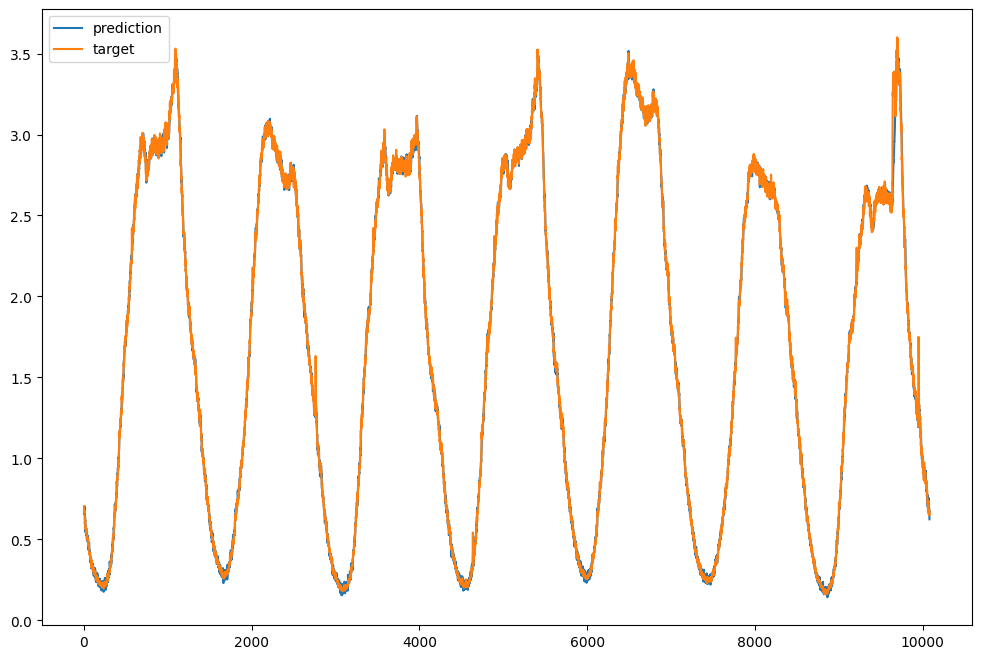

In [68]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [69]:
np.array(pred_list)

array([0.66074169, 0.6944446 , 0.67234516, ..., 0.67516851, 0.67053419,
       0.62369972])

In [70]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.704112],
       [0.689872],
       [0.666568],
       ...,
       [0.678984],
       [0.653888],
       [0.649888]])

In [71]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [76]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

2.084995247423649 %


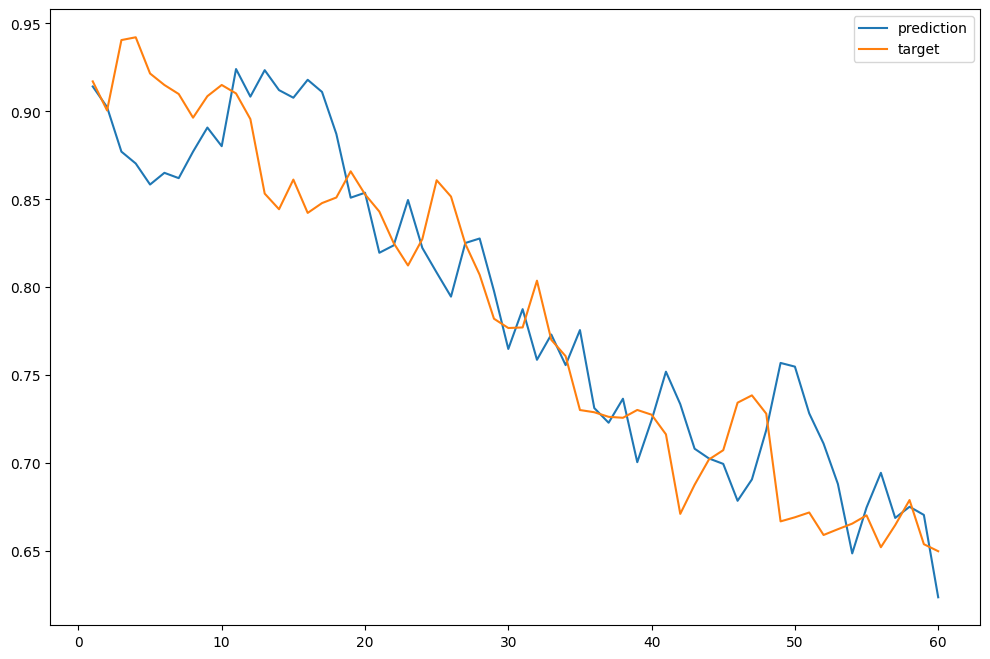

In [73]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [74]:
len(time_list)

10080

In [75]:
np.mean(time_list) 

0.28562135119286797

<font color = blue><font size = 6> Conclusion </font></font><br>
훈련을 하지 않았을때는 8퍼센트의 결과를 보였고 이해 비해서 0.3 퍼센트의 결과는 매우 좋은 결과이다 데이터의 의존성이 큰 DLinear,NLinear등은 이러한 결과가 변동성이 큰 데이터에서도 똑같이 적용될 것이라고 생각된다